# 合并（子图+annotation） 到 原图 + 过滤掉其他类别目标
将多个子图+annotation合并到完整的原图片中

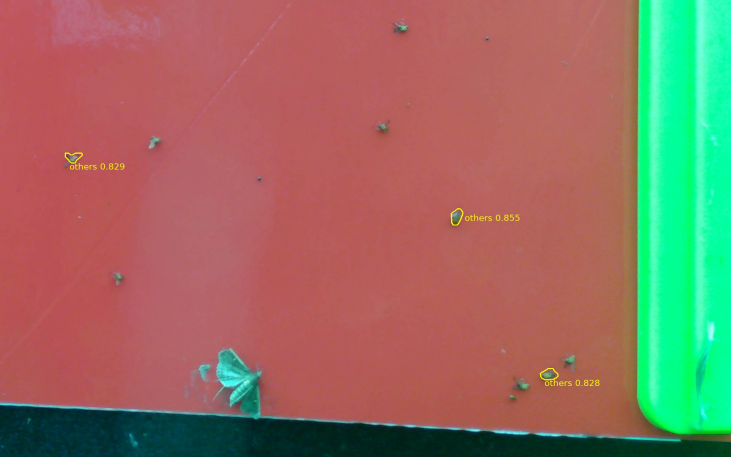


✅ 1. 已保存筛选后的标注: /workspace/models/SAHI/run_v3/data_sliced_v2_merge/filtered_annotations.json

✅ 2. 已保存可视化结果: /workspace/models/SAHI/run_v3/data_sliced_v2_merge/filtered_visualizations

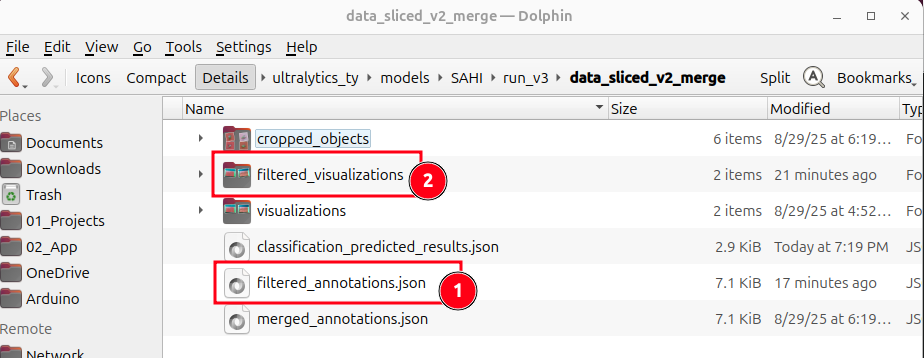

## 之前的步骤输出

之前的02_02处理后结果:

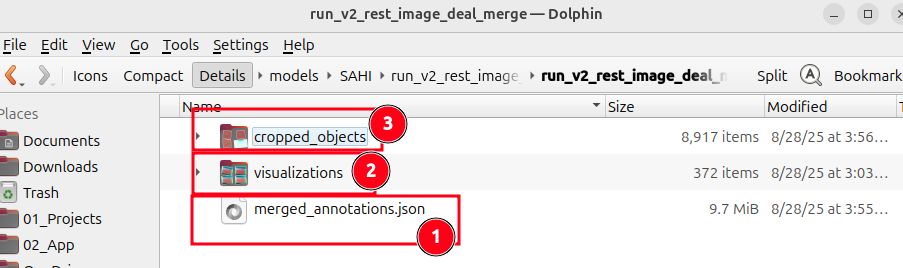

之前的03_01处理后结果:

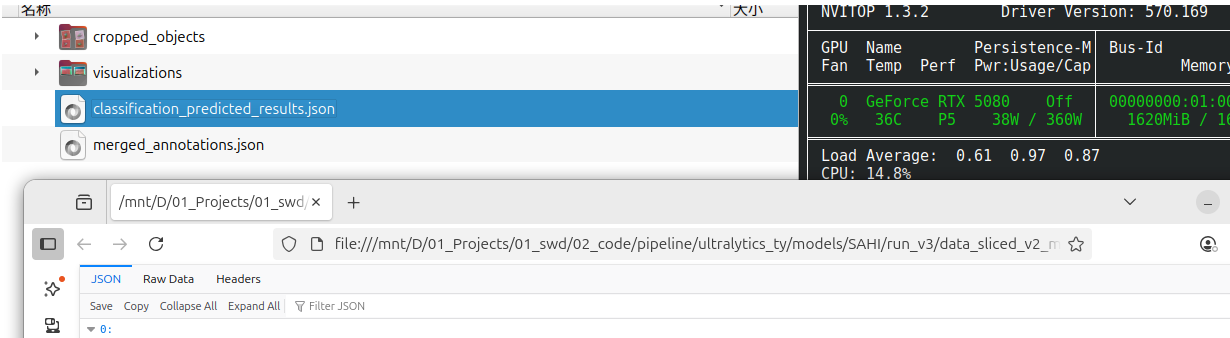

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import json
from pathlib import Path
from typing import Dict, List, Optional
from PIL import Image, ImageDraw, ImageFont

# ========= 配置（根据需要修改） =========
ORIGINAL_IMAGE_DIR  = Path("/workspace/models/SAHI/run_v3/data")          # 原图目录
CLASSIFICATION_JSON = Path("/workspace/models/SAHI/run_v3/data_sliced_v2_merge/classification_predicted_results.json")
MERGED_ANN_JSON     = Path("/workspace/models/SAHI/run_v3/data_sliced_v2_merge/merged_annotations.json")  # 你前面“拼回大图”的输出
FILTERED_ANN_JSON   = Path("/workspace/models/SAHI/run_v3/data_sliced_v2_merge/filtered_annotations.json")
OUT_VIS_DIR         = Path("/workspace/models/SAHI/run_v3/data_sliced_v2_merge/filtered_visualizations")

# 过滤策略（三选一，自行调整）
DROP_CLASSES: Optional[List[str]] = None   # 丢弃这些类
KEEP_CLASSES: Optional[List[str]] = ["others"]         # 仅保留这些类（优先于 DROP）
RENAME_WITH_PRED: bool = True                    # True=用 top1_name 覆盖 ann["label"]（常用于“修正标签”）

# 文本样式
LINE_COLOR = "yellow"
LINE_WIDTH = 4
TEXT_FONT = "DejaVuSans"     # 系统常有的字体；如需中文可换 "SimHei"
TEXT_SIZE = 28
TEXT_FILL = "yellow"


# ========= 工具函数 =========
def load_cls_map(path: Path) -> Dict[str, Dict]:
    """
    读取 classification_predicted_results.json，并建立 uuid -> 预测信息 的映射。
    兼容两种结构：
        1) 纯列表 [{"uuid":..., "top1_name":..., ...}, ...]
        2) 包含 summary/results 的 dict（之前的“进阶版”）
    """
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    if isinstance(data, dict) and "results" in data:
        items = data["results"]
    elif isinstance(data, list):
        items = data
    else:
        raise ValueError("classification_predicted_results.json 结构不支持")

    m = {}
    for it in items:
        u = it.get("uuid")
        if not u:
            # 兼容你文件名里带 uuid 的情况：有些版本没放在字段里
            # 但你前面明确说这个文件里有 uuid 字段，这里就不做额外解析了
            continue
        m[u] = it
    return m


def filter_annotations(merged_annotations: Dict[str, List[dict]],
                        cls_map: Dict[str, dict],
                        keep: Optional[List[str]],
                        drop: Optional[List[str]],
                        relabel: bool) -> Dict[str, List[dict]]:
    """
    按 uuid 对齐，并依据 keep/drop 规则筛选；可选用 top1_name 覆盖原 label。
    """
    out = {}
    kept, dropped, not_found = 0, 0, 0

    for img, anns in merged_annotations.items():
        new_list = []
        for ann in anns:
            u = ann.get("uuid")
            if not u:
                continue
            pred = cls_map.get(u)
            if not pred:
                # 这个 uuid 没有分类结果——通常表示已被移除或未参与分类
                not_found += 1
                continue

            top1 = pred.get("top1_name")
            if keep is not None:
                if top1 not in keep:
                    dropped += 1
                    continue
            elif drop is not None:
                if top1 in drop:
                    dropped += 1
                    continue

            # 通过筛选：可选—用分类名覆盖原 label
            if relabel and top1:
                ann = dict(ann)        # 不污染原数据
                ann["label"] = top1

            new_list.append(ann)
            kept += 1

        if new_list:
            out[img] = new_list

    print(f"Filter summary -> kept: {kept}, dropped: {dropped}, uuid_without_pred: {not_found}")
    return out


def visualize(annotations: Dict[str, List[dict]], original_dir: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    font = ImageFont.truetype(TEXT_FONT, size=TEXT_SIZE)

    for image_name, anns in annotations.items():
        # 原图路径（你的原图可能带 uuid 后缀，做个模糊匹配兜底）
        img_path = original_dir / f"{image_name}.jpg"
        if not img_path.exists():
            stem = image_name.split("jpg")[0]
            candidates = [p for p in original_dir.glob("*.jpg") if p.name.startswith(stem)]
            if candidates:
                img_path = candidates[0]
        if not img_path.exists():
            continue

        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        for ann in anns:
            pts = ann["points"]
            pts_int = [tuple(map(int, p)) for p in pts]
            # polygon
            draw.polygon(pts_int, outline=LINE_COLOR, width=LINE_WIDTH)
            # 文本：类别 + 分数（可无）
            s = ann.get("score")
            label_txt = f"{ann['label']} {s:.3f}" if isinstance(s, (float, int)) else str(ann["label"])
            x0, y0 = pts_int[0]
            draw.text((x0 + 15, y0 + 15), label_txt, fill=TEXT_FILL, font=font)

        out_path = out_dir / f"{image_name}_vis.jpg"
        img.save(out_path)


# ========= 主流程 =========
if __name__ == "__main__":
    # 1) 读入分类结果（uuid -> top1_name/score/...）
    cls_map = load_cls_map(CLASSIFICATION_JSON)

    # 2) 读入合并后的原图标注（uuid 在这里与分类文件对齐）
    with MERGED_ANN_JSON.open("r", encoding="utf-8") as f:
        merged = json.load(f)

    # 3) 过滤 +（可选）重命名标签
    filtered = filter_annotations(
        merged_annotations=merged,
        cls_map=cls_map,
        keep=KEEP_CLASSES,
        drop=DROP_CLASSES,
        relabel=RENAME_WITH_PRED
    )

    # 4) 保存筛选后的标注
    FILTERED_ANN_JSON.parent.mkdir(parents=True, exist_ok=True)
    with FILTERED_ANN_JSON.open("w", encoding="utf-8") as f:
        json.dump(filtered, f, indent=2)
    print(f"✅ 1. 已保存筛选后的标注: {FILTERED_ANN_JSON}")

    # 5) 可视化
    visualize(filtered, ORIGINAL_IMAGE_DIR, OUT_VIS_DIR)
    print(f"✅ 2. 已保存可视化结果: {OUT_VIS_DIR}")

Filter summary -> kept: 6, dropped: 0, uuid_without_pred: 0
✅ 1. 已保存筛选后的标注: /workspace/models/SAHI/run_v3/data_sliced_v2_merge/filtered_annotations.json
✅ 2. 已保存可视化结果: /workspace/models/SAHI/run_v3/data_sliced_v2_merge/filtered_visualizations
